# Fix Exploding Gradients with Gradient Clipping

Training a neural network can become unstable given the choice of an error function, learning rate, or even the scale of the target variable. During training, large updates to weights can cause a numerical overflow or underflow, often referred to as exploding gradients. The problem of exploding gradients is more common with recurrent neural networks, such as LSTMs, given the accumulation of gradients unrolled over hundreds of input time steps. A common and relatively easy solution to the exploding gradients problem is to change the derivative of the error before propagating it backward through the network and using it to update the weights. Two approaches include rescaling the gradients given a chosen vector norm and clipping gradient values that exceed a preferred range. Together, these methods are referred to as gradient clipping. This tutorial will discover the exploding gradient problem and how to improve neural network training stability using gradient clipping. After completing this tutorial, you will know:

* Training neural networks can become unstable, leading to a numerical overflow or underflow referred to as exploding gradients.
* The training process can be made stable by changing the error gradients by scaling the vector norm or clipping gradient values.
* How to update an MLP model for a regression predictive modeling problem with exploding gradients to have a stable training process using gradient clipping methods.


## Exploding Gradients and Clipping

Neural networks are trained using the stochastic gradient descent optimization algorithm. This requires first the estimation of the loss on one or more training examples, then calculating the derivative of the loss, which is propagated backward through the network to update the weights. Weights are updated using a fraction of the backpropagated error controlled by the learning rate. It is possible for the updates to the weights to be so large that the weights either overflow or underflow their numerical precision. In practice, the weights can take on the value of a NaN (not a number) or Inf (infinity) when they overflow or underflow, and for practical purposes, the network will be useless from that point forward, forever predicting NaN values as signals flow through the invalid weights.

The underflow or overflow of weights is generally referred to as an instability of the network training process and is known by the name exploding gradients as the unstable training process causes the network to fail to train so that the model is essentially useless. This can happen due to a poor configuration choice in a given neural network, such as a Convolutional Neural Network or Multilayer Perceptron. Some examples include:

* Poor choice of learning rate that results in large weight updates.
* Poor choice of data preparation, allowing large differences in the target variable.
* Poor choice of the loss function, allowing the calculation of large error values.

Exploding gradients is also a problem in recurrent neural networks such as the Long Short-Term Memory network, given the accumulation of error gradients in the unrolled recurrent structure. Exploding gradients can be avoided generally by careful configuration of the network model, such as choosing the small learning rate, scaled target variables, and a standard loss function. Nevertheless, exploding gradients may still be an issue with recurrent networks with a large number of input time steps.

A common solution to exploding gradients is changing the error derivative before propagating it backward through the network and updating the weights. By rescaling the error derivative, the updates to the weights will also be rescaled, dramatically decreasing the likelihood of an overflow or underflow. There are two main methods for updating the error derivative; they are:

* Gradient Scaling.
* Gradient Clipping.

Gradient scaling involves normalizing the error gradient vector such that vector norm (magnitude) equals a defined value, such as 1.0.

Gradient clipping involves forcing the gradient values (element-wise) to a specific minimum or maximum value if the gradient exceeds an expected range. Together, these methods are often referred to as gradient clipping.

It is a method that only addresses the numerical stability of training deep neural network models and does not offer any general improvement in performance. The value for the gradient vector norm or preferred range can be configured by trial and error, by using common values used in the literature, or by first observing common vector norms or ranges via experimentation and then choosing a sensible value.

It is common to use the same gradient clipping configuration for all layers in the network. Nevertheless, there are examples where a larger range of error gradients is permitted in the output layer compared to hidden layers.

## Gradient Clipping Keras API

Keras supports gradient clipping on each optimization algorithm, with the same scheme applied to all layers in the model. Gradient clipping can be used with an optimization algorithm, such as stochastic gradient descent, including an additional argument when configuring the optimization algorithm. Two types of gradient clipping can be used: gradient norm scaling and gradient value clipping.

### Gradient Norm Scaling

Gradient norm scaling involves changing the derivatives of the loss function to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value. For example, we could specify a norm of 1.0, meaning that if the vector norm for a gradient exceeds 1.0, then the values in the vector will be rescaled so that the norm of the vector equals 1.0. This can be used in Keras by specifying the `clipnorm` argument on the optimizer; for example:

```
...
# configure sgd with gradient norm clipping
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
```

### Gradient Value Clipping

Gradient value clipping involves clipping the derivatives of the loss function to have a given value if a gradient value is less than a negative threshold or more than the positive threshold. For example, we could specify a norm of 0.5, meaning that if a gradient value was less than -0.5, it is set to -0.5, and if it is more than 0.5, it will be set to 0.5. This can be used in Keras by specifying the `clipvalue` argument on the optimizer, for example:

```
...
# configure sgd with gradient value clipping
opt = SGD(lr=0.01, momentum=0.9, clipvalue=0.5)
```

## Gradient Clipping Case Study

This section will demonstrate using gradient clipping to counter the exploding gradients problem with an MLP on a simple classification problem. This example provides a template for exploring gradient clipping with your neural network for classification and regression problems.

### Regression Predictive Modeling Problem

A regression predictive modeling problem involves predicting a real-valued quantity. We can use a standard regression problem generator provided by the scikit-learn library to `make_regression()` function. This function will generate examples from a simple regression problem with a given number of input variables, statistical noise, and other properties. We will use this function to define a problem with 20 input features; 10 of the features will be meaningful, and ten will not be relevant. A total of 1,000 examples will be randomly generated. The pseudorandom number generator will be fixed to ensure that we get the same 1,000 examples each time the code is run.

```
# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)
```

Each input variable has a Gaussian distribution, as does the target variable. We can create plots of the target variable showing both the distribution and spread. The complete example is listed below.

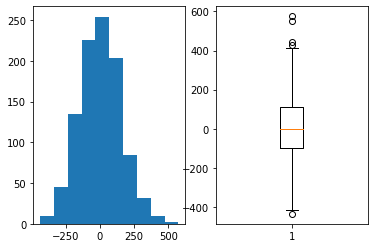

In [1]:
# regression predictive modeling problem
from sklearn.datasets import make_regression
from matplotlib import pyplot

# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# histogram of target variable
pyplot.subplot(121)
pyplot.hist(y)

# boxplot of target variable
pyplot.subplot(122)
pyplot.boxplot(y)
pyplot.show()

Running the example creates a figure with two plots showing a histogram and a box and whisker plot of the target variable. The histogram shows the Gaussian distribution of the target variable. The box and whisker plot shows that the range of samples varies between -400 to 400, with a mean of about 0.0.

### Multilayer Perceptron With Exploding Gradients

We can develop a Multilayer Perceptron (MLP) model for the regression problem. A model will be demonstrated on the raw data without scaling the input or output variables. This is a good example to demonstrate exploding gradients as a model trained to predict the unscaled target variable will result in error gradients with values in the hundreds or even thousands, depending on the batch size used during training. Such large gradient values are likely to lead to unstable learning or an over ow of the weight values. The first step is to split the data into train and test sets so that we can fit and evaluate a model. We will generate 1,000 examples from the domain and split the dataset in half, using 500 train and test sets.

In [6]:
# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

Next, we can define an MLP model. The model will expect 20 inputs in the 20 input variables in the problem. A single hidden layer will be used with 25 nodes and a rectified linear activation function. The output layer has one node for the single target variable and a linear activation function to predict real values directly.

In [7]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

The mean squared error loss function will be used to optimize the model, and the stochastic gradient descent optimization algorithm will be used with the sensible default configuration of a learning rate of 0.01 and a momentum of 0.9.

In [8]:
from tensorflow.keras.optimizers import SGD

# compile model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))

The model will be fit for 100 training epochs, and the test set will be used as a validation set, evaluated at the end of each training epoch.

In [9]:
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

The mean squared error is calculated on the train and test datasets at the end of training to get an idea of how well the model learned the problem.

In [10]:
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)

Finally, learning curves of mean squared error on the train and test sets at the end of each training epoch are graphed using line plots, providing learning curves to get an idea of the dynamics of the model while learning the problem.

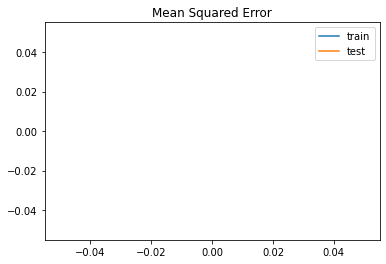

In [13]:
# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Tying these elements together, the complete example is listed below.

Train: nan, Test: nan


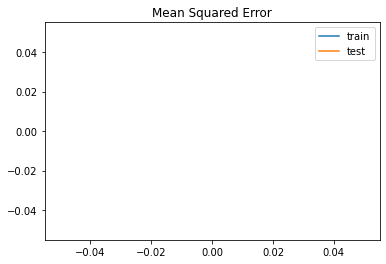

In [14]:
# mlp with unscaled data for the regression problem
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Running the example fits the model and calculates the mean squared error on the train and test sets. In this case, the model is unable to learn the problem, resulting in predictions of NaN values. The model weights exploded during training given the very large errors and, in turn, error gradients calculated for weight updates.

A line plot of training history is created but does not show anything as the model almost immediately results in a NaN mean squared error. This demonstrates that some intervention is required with regard to the target variable for the model to learn this problem. A traditional solution would be to rescale the target variable using either standardization or normalization, and this approach is recommended for MLPs. Nevertheless, an alternative that we will investigate in this case will be the use of gradient clipping.

### MLP With Gradient Norm Scaling

We can update the training of the model in the previous section to add gradient norm scaling. This can be implemented by setting the clipnorm argument on the optimizer. For example, the gradients can be rescaled to have a vector norm (magnitude or length) of 1.0, as follows:

In [15]:
# compile model
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt)

The complete example of this change is listed below.

In [16]:
# mlp with unscaled data for the regression problem with gradient norm scaling
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
opt = SGD(lr=0.01, momentum=0.9, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt)

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.615, Test: 17.555


Running the example fits the model and evaluates it on the train and test sets, printing the mean squared error.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, we can see that scaling the gradient with a vector norm of 1.0 has resulted in a stable model capable of learning the problem and converging on a solution.

A line plot is also created showing the means squared error loss on the train and test datasets over training epochs. The plot shows how loss dropped from large values above 20,000 down to small values below 100 rapidly over 20 epochs.

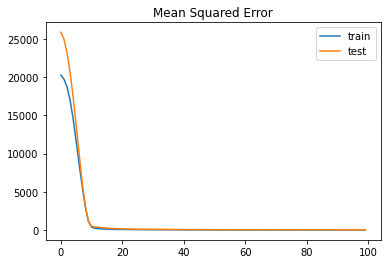

In [17]:
# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

There is nothing special about the vector norm value of 1.0, and other values could be evaluated and the performance of the resulting model compared.

### MLP With Gradient Value Clipping

Another solution to the exploding gradient problem is to clip the gradient if it becomes too large or small. We can update the training of the MLP to use gradient clipping by adding the `clipvalue` argument to the optimization algorithm configuration. For example, the code below clips the gradient to the range [-5 to 5].

In [18]:
# compile model
opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
model.compile(loss='mean_squared_error', optimizer=opt)

The complete example of training the MLP with gradient clipping is listed below.

In [19]:
# mlp with unscaled data for the regression problem with gradient clipping
from sklearn.datasets import make_regression
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from matplotlib import pyplot

# generate regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=1)

# split into train and test
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

# define model
model = Sequential()
model.add(Dense(25, input_dim=20, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))

# compile model
opt = SGD(lr=0.01, momentum=0.9, clipvalue=5.0)
model.compile(loss='mean_squared_error', optimizer=opt)

# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)

# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 284.333, Test: 316.960


Running this example fits the model and evaluates it on the train and test sets, printing the mean squared error.

**Note**: Your specific results may vary, given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In this case, the model can learn the problem without exploding gradients, achieving an MSE of below ten on both the train and test sets.

A line plot is also created showing the means squared error loss on the train and test datasets over training epochs. The plot shows that the model learns the problem quickly, achieving a sub-100 MSE loss within a few training epochs.

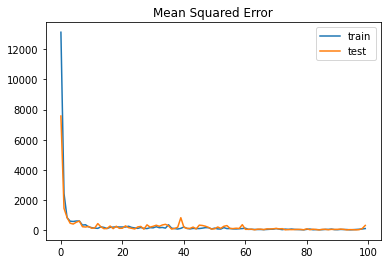

In [20]:
# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

A clipped range of [-5, 5] was chosen arbitrarily; you can experiment with different sized ranges and compare the learning speed and final model performance.

**Extensions**

This section lists some ideas for extending the tutorial that you may wish to explore.

* Vector Norm Values. Update the example to evaluate different gradient vector norm values and compare performance.
* Vector Clip Values. Update the example to evaluate different gradient value ranges and compare performance.
* Vector Norm and Clip. Update the example to use a combination of vector norm scaling and vector value clipping on the same training run and compare performance.

**Summary**

In this tutorial, you discovered the exploding gradient problem and how to improve neural network training stability using gradient clipping. Specifically, you learned:

* Training neural networks can become unstable, leading to a numerical overflow or underflow referred to as exploding gradients.
* The training process can be made stable by changing the error gradients by scaling the vector norm or clipping gradient values to a range.
* How to update an MLP model for a regression predictive modeling problem with exploding gradients to have a stable training process using gradient clipping methods.